In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

from pathlib import PurePath, Path
import pyarrow

In [2]:
def read_kibot_ticks(fp):
    cols = list(map(str.lower,['Date','Time','Price','Bid','Ask','Size']))
    df = (pd.read_csv(fp, header=None)
          .rename(columns=dict(zip(range(len(cols)),cols)))
          .assign(dates=lambda df: (pd.to_datetime(df['date']+df['time'],
                                                  format='%m/%d/%Y%H:%M:%S')))
          .assign(v=lambda df: df['size']) # volume
          .assign(dv=lambda df: df['price']*df['size']) # dollar volume
          .drop(['date','time'],axis=1)
          .set_index('dates')
          .drop_duplicates())
    return df

In [4]:
data = PurePath('data/IVE_tickbidask.csv')
df = read_kibot_ticks(data)
print(df)

                        price     bid     ask   size      v            dv
dates                                                                    
2009-09-28 09:30:00   50.7900   50.70   50.79    100    100  5.079000e+03
2009-09-28 09:30:00   50.7100   50.70   50.79    638    638  3.235298e+04
2009-09-28 09:31:32   50.7500   50.75   50.76    100    100  5.075000e+03
2009-09-28 09:31:33   50.7500   50.72   50.75    100    100  5.075000e+03
2009-09-28 09:31:50   50.7500   50.73   50.76    300    300  1.522500e+04
2009-09-28 09:31:51   50.7500   50.74   50.76    300    300  1.522500e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    300    300  1.523400e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    500    500  2.539000e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    100    100  5.078000e+03
2009-09-28 09:32:56   50.8226   50.81   50.83    100    100  5.082260e+03
2009-09-28 09:33:02   50.8100   50.80   50.81    500    500  2.540500e+04
2009-09-28 09:33:02   50.8100   50.80 

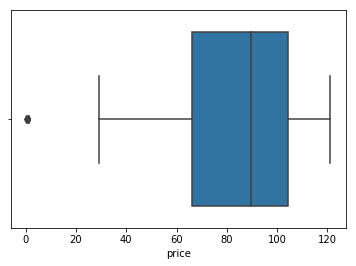

In [5]:
# Remove data errors
sns.boxplot(df.price)

In [6]:
def mad_outlier(y, thresh=3.):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

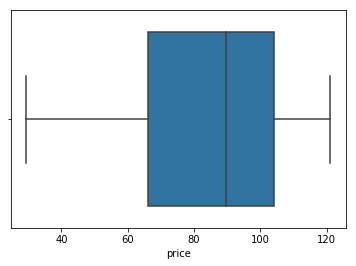

In [7]:
mad = mad_outlier(df.price.values.reshape(-1,1))
df.loc[mad]
sns.boxplot(df.loc[~mad].price)

In [8]:
df_clean = df.loc[~mad]
print(df_clean)

                        price     bid     ask   size      v            dv
dates                                                                    
2009-09-28 09:30:00   50.7900   50.70   50.79    100    100  5.079000e+03
2009-09-28 09:30:00   50.7100   50.70   50.79    638    638  3.235298e+04
2009-09-28 09:31:32   50.7500   50.75   50.76    100    100  5.075000e+03
2009-09-28 09:31:33   50.7500   50.72   50.75    100    100  5.075000e+03
2009-09-28 09:31:50   50.7500   50.73   50.76    300    300  1.522500e+04
2009-09-28 09:31:51   50.7500   50.74   50.76    300    300  1.522500e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    300    300  1.523400e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    500    500  2.539000e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    100    100  5.078000e+03
2009-09-28 09:32:56   50.8226   50.81   50.83    100    100  5.082260e+03
2009-09-28 09:33:02   50.8100   50.80   50.81    500    500  2.540500e+04
2009-09-28 09:33:02   50.8100   50.80 

In [9]:
df = df_clean
outfp = PurePath('data/clean_IVE_ticks.parq')
df.to_parquet(outfp)

In [10]:
del df

In [11]:
data_f = PurePath('data/clean_IVE_ticks.parq')
df = pd.read_parquet(data_f)
print(df)

                        price     bid     ask   size      v            dv
dates                                                                    
2009-09-28 09:30:00   50.7900   50.70   50.79    100    100  5.079000e+03
2009-09-28 09:30:00   50.7100   50.70   50.79    638    638  3.235298e+04
2009-09-28 09:31:32   50.7500   50.75   50.76    100    100  5.075000e+03
2009-09-28 09:31:33   50.7500   50.72   50.75    100    100  5.075000e+03
2009-09-28 09:31:50   50.7500   50.73   50.76    300    300  1.522500e+04
2009-09-28 09:31:51   50.7500   50.74   50.76    300    300  1.522500e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    300    300  1.523400e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    500    500  2.539000e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    100    100  5.078000e+03
2009-09-28 09:32:56   50.8226   50.81   50.83    100    100  5.082260e+03
2009-09-28 09:33:02   50.8100   50.80   50.81    500    500  2.540500e+04
2009-09-28 09:33:02   50.8100   50.80 

In [12]:
n_ticks = df.shape[0]
volume_ratio = (df.v.sum()/n_ticks).round()
dollar_ratio = (df.dv.sum()/n_ticks).round()
print(f'num ticks: {n_ticks:,}')
print(f'volume ratio: {volume_ratio}')
print(f'dollar ratio: {dollar_ratio}')

num ticks: 1,587,982
volume ratio: 549.0
dollar ratio: 47963.0


In [13]:
tick_M = 100
print(f'tick threshold: {tick_M:,}')


tick threshold: 100


In [14]:
df_all_ticks = df

In [15]:
df_tick = df_all_ticks[::tick_M]

In [16]:
# date = '2019-01-04'
date = '2009-10-01'
date_ticks = df_tick['price'].loc[date]
all_date_ticks = df_all_ticks['price'].loc[date]
date_ticks.shape, all_date_ticks.shape

((15,), (1466,))

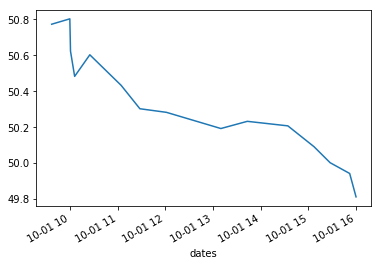

In [17]:
date_ticks.plot()

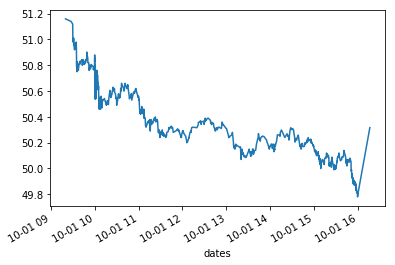

In [18]:
all_date_ticks.plot()

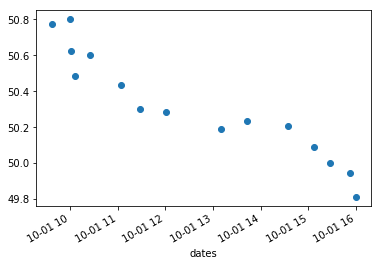

In [19]:
date_ticks.plot(style='o')

In [20]:
vol_col = df_all_ticks['v']
vol = 0
vol_cutoff = 10_000
idx = []
for i, x in enumerate(vol_col):
    vol += x
    if vol >= vol_cutoff:
        idx.append(i)
        vol = 0

df_vol = df_all_ticks.iloc[idx].drop_duplicates()

In [21]:
date = '2009-10-01'
date_vols = df_vol['price'].loc[date]
date_vols.shape

(48,)

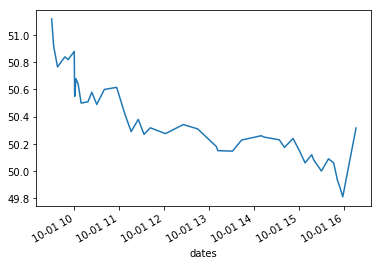

In [22]:
date_vols.plot()

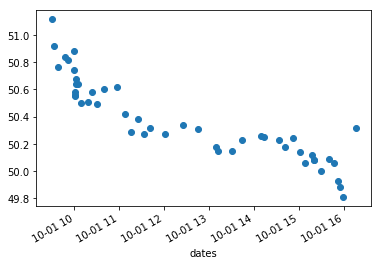

In [23]:
date_vols.plot(style='o')

In [24]:
dol_col = df_all_ticks['dv']
dol = 0
dol_cutoff = 1_000_000
idx = []
for i, x in enumerate(dol_col):
    dol += x
    if dol >= dol_cutoff:
        idx.append(i)
        dol = 0

df_dol = df_all_ticks.iloc[idx].drop_duplicates()

In [25]:
date = '2009-10-01'
date_dols = df_dol['price'].loc[date]
date_dols.shape

(26,)

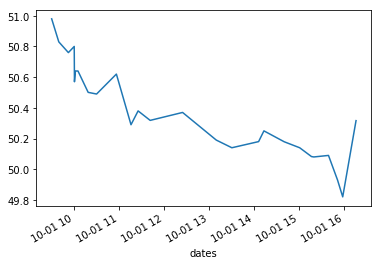

In [26]:
date_dols.plot()

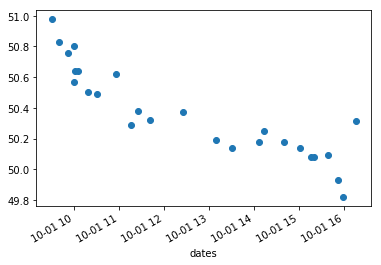

In [27]:
date_dols.plot(style='o')

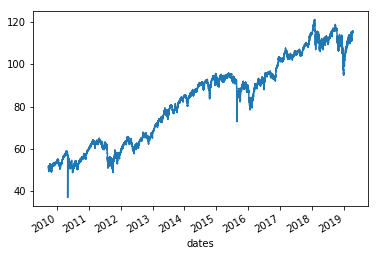

In [28]:
df_dol['price'].plot()

In [67]:
# Analyze bars 2.1b
tick_count = df_tick.groupby(pd.TimeGrouper('1W'))['price'].count()
vol_count = df_vol.groupby(pd.TimeGrouper('1W'))['price'].count()
dol_count = df_dol.groupby(pd.TimeGrouper('1W'))['price'].count()
df_all_count = df_all_ticks.groupby(pd.TimeGrouper('1W'))['price'].count()

C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  after removing the cwd from sys.path.
C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """


In [68]:
# Scale to range of 0,1
tc = (tick_count - tick_count.min())/(tick_count.max() - tick_count.min())
vc = (vol_count - vol_count.min())/(vol_count.max() - vol_count.min())
dc = (dol_count - dol_count.min())/(dol_count.max() - dol_count.min())
dfc = (df_all_count - df_all_count.min())/(df_all_count.max() - df_all_count.min())

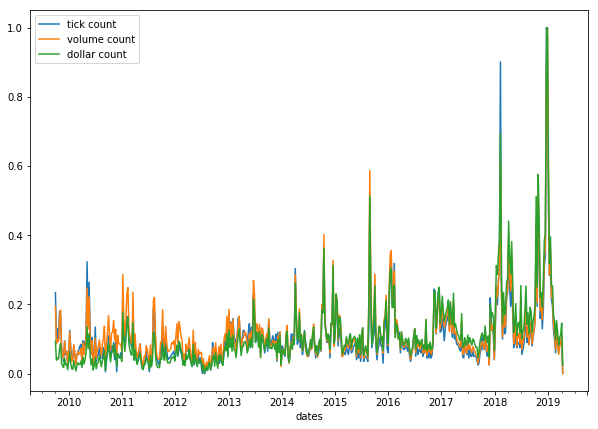

In [64]:
# Plot time series of count
f,ax=plt.subplots(figsize=(10,7))
tc.plot(ax=ax, label='tick count')
vc.plot(ax=ax, label='volume count')
dc.plot(ax=ax, label='dollar count')
ax.legend()

In [83]:
# Stability count
names = ['tick', 'vol', 'dol', 'all_ticks']
count = pd.Series([tc.std(), vc.std(), dc.std(), dfc.std()], index=names)
count.sort_values()

vol          0.095049
tick         0.097791
all_ticks    0.097945
dol          0.103696
dtype: float64

In [82]:
# Serial Correlation
t_ret = pd.Series(np.diff(np.log(df_tick.price)), index=df_tick.price.index[1:])
vol_ret = pd.Series(np.diff(np.log(df_vol.price)), index=df_vol.price.index[1:])
dol_ret = pd.Series(np.diff(np.log(df_dol.price)), index=df_dol.price.index[1:])
df_ret = pd.Series(np.diff(np.log(df_all_ticks.price)), index=df_all_ticks.price.index[1:])

In [88]:
rets = [t_ret, vol_ret, dol_ret, df_ret]
data = {}
for b, br in zip(names, rets):
    data[b] = (br.shape[0], pd.Series.autocorr(br))

acorr_df = pd.DataFrame.from_dict(data).T
acorr_df.abs().sort_values(1)

,0,1
vol,67354.0,0.017051
tick,15879.0,0.040413
all_ticks,1587981.0,0.092742
dol,58287.0,0.118386


In [94]:
# Variance of returns
t_ret_var = t_ret.resample('1M').var()
vol_ret_var = vol_ret.resample('1M').var()
dol_ret_var = dol_ret.resample('1M').var()
df_ret_var = df_ret.resample('1M').var()

In [95]:
month_vars = [t_ret_var, vol_ret_var, dol_ret_var, df_ret_var]
data = {}
for b, br in zip(names, month_vars):
    data[b] = (br.shape[0], np.var(br))

var_df = pd.DataFrame.from_dict(data).T
var_df.sort_values(1)

,0,1
all_ticks,116.0,5.026459e-12
tick,116.0,1.556877e-09
dol,116.0,1.993346e-09
vol,116.0,2.571963e-09


In [100]:
# Jarque-Bera test - Far from zero => not normally distributed
def jarque_bera(x):
    np.random.seed(73)
    return stats.jarque_bera(x)[0]

In [103]:
data = {}
for b, br in zip(names, rets):
    data[b] = (br.shape[0], jarque_bera(br))

jb_df = pd.DataFrame.from_dict(data).T
jb_df.sort_values(1)

,0,1
tick,15879.0,8.454128e+07
dol,58287.0,7.132692e+10
vol,67354.0,4.182380e+11
all_ticks,1587981.0,2.677946e+14


In [104]:
# 2.2

# Calc imbalance dollar bars
def getImbalance(t):
    bs = np.zeros_like(t)
    for i in np.arange(1, bs.shape[0]):
        t_bt = bt(t[i-1], t[i], bs[:i-1])
        bs[i-1] = t_bt
    return bs[:-1] # remove last value

In [126]:
test_df = df_all_ticks[:10_000]

In [135]:
p0 = None
b = []
bigT = 0
thres = 10
for i, tick in enumerate(test_df.iterrows()):
    if p0 is None:
        p0 = tick[1].price
        b.append(1)
    else:
        if tick[1].price > p0:
#             print('up')
#             print(tick[1].dv)
            b.append(1)
        elif tick[1].price < p0:
#             print('down')
#             print(tick[1].dv * -1)
            b.append(-1)
        else:
#             print('same')
            b.append(b[-1])
        p0 = tick[1].price
    bigT += b[-1]
    if bigT > thres:
        print('SAMPLE BRAH')
        bigT = 0
#         print(tick)
        print(i)

SAMPLE BRAH
46
SAMPLE BRAH
63
SAMPLE BRAH
76
SAMPLE BRAH
203
SAMPLE BRAH
306
SAMPLE BRAH
353
SAMPLE BRAH
490
SAMPLE BRAH
521
SAMPLE BRAH
576
SAMPLE BRAH
589
SAMPLE BRAH
600
SAMPLE BRAH
623
SAMPLE BRAH
8914
SAMPLE BRAH
9253
SAMPLE BRAH
9338
SAMPLE BRAH
9363
SAMPLE BRAH
9520
SAMPLE BRAH
9577
SAMPLE BRAH
9814
SAMPLE BRAH
9917


In [131]:
test_df

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.7900,50.70,50.79,100,100,5079.0000
2009-09-28 09:30:00,50.7100,50.70,50.79,638,638,32352.9800
2009-09-28 09:31:32,50.7500,50.75,50.76,100,100,5075.0000
2009-09-28 09:31:33,50.7500,50.72,50.75,100,100,5075.0000
2009-09-28 09:31:50,50.7500,50.73,50.76,300,300,15225.0000
2009-09-28 09:31:51,50.7500,50.74,50.76,300,300,15225.0000
2009-09-28 09:32:06,50.7800,50.76,50.78,300,300,15234.0000
2009-09-28 09:32:06,50.7800,50.76,50.78,500,500,25390.0000
2009-09-28 09:32:06,50.7800,50.76,50.78,100,100,5078.0000


In [5]:
data = PurePath('data/IVE_tickbidask.csv')


PureWindowsPath('data/IVE_tickbidask.csv')

In [8]:
pre, ext = os.path.splitext(data)

In [7]:
import os

In [9]:
pre

'data\\IVE_tickbidask'

In [10]:
ext

'.csv'